<a href="https://colab.research.google.com/github/Weff24/PrivacyPlate/blob/main/pp_blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Extraction from XML Files

In [37]:
from google.colab import drive, files
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import xml.etree.ElementTree as ET
import os
import sys
from collections import defaultdict

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image

In [21]:
!pip install kornia

In [22]:
import kornia

In [ ]:
!pip install -U yolov5

# 1. Test XML Data Extraction: License Plate Crop Borders

In [64]:
# Path to annotation folder
annot_dir_path = Path("/content/drive/MyDrive/01-License Plates/annotations")

if not annot_dir_path.exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# Extract the box from xml files
box_locations = defaultdict(list)
box_sizes = defaultdict(list)
box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location
box_size_elements = ['width', 'height'] # order of image size

for path in os.listdir(annot_dir_path):
    tree = ET.parse(f'{annot_dir_path}/{path}')  # Replace 'your_xml_file.xml' with your XML file path
    root = tree.getroot()

    # Get key from XML
    xml_ind =int(path[4:-4])

    for element in box_elements:
        box_locations[xml_ind].append(int(root.find('object').find('bndbox').find(element).text))

    for element in box_size_elements:
        box_sizes[xml_ind].append(int(root.find('size').find(element).text))

max_w = 0
max_h = 0
for w, h in box_sizes.values():
    if max_w < w:
        max_w = w
    if max_h < h:
        max_h = h

print('Max Width = ', max_w)
print('Max Height = ', max_h)

Max Width =  600
Max Height =  531


# 2. Test License Plate Image Data Import

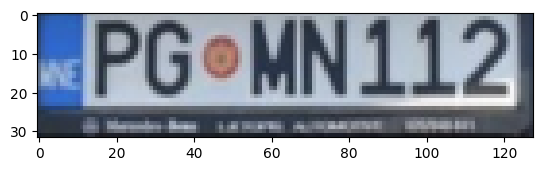

In [214]:
%matplotlib inline

img_dir_path = Path("/content/drive/MyDrive/01-License Plates/paddedimages")

if not img_dir_path.exists():
  print("Image directory path does not exist")
  sys.exit(1)

cropped_plate_images = []
plate_images = []

i = 0
for i, path in enumerate(os.listdir(img_dir_path)):
  plate_image = mpimg.imread(f"{img_dir_path}/{path}")
  fig, ax = plt.subplots()

  box = box_locations[int(path[4:-4])]
  cropped_plate_image = plate_image[box[1]:box[3],box[0]:box[2]]

  ax.imshow(cropped_plate_image)
#   plt.axis("off")
#   plt.savefig("/content/drive/MyDrive/01-License Plates/croppedimages/test.png")
  plt.show()

  plate_images.append((plate_image, box))
  cropped_plate_images.append((cropped_plate_image, box))

  i += 1
  if i == 1:
    break

In [211]:
plt.close()

In [212]:
# Round up to nearest odd integer for kernel size
def to_nearest_odd(n):
    if n % 2 == 0:
        return n + 1
    return n

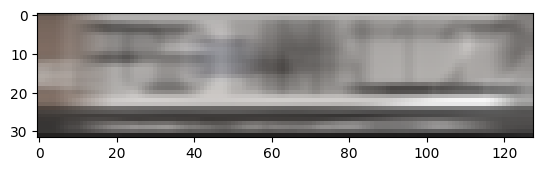

In [213]:
cropped_plate_image = cropped_plate_images[-1][0]
cropped_plate_image_tensor = torch.from_numpy(cropped_plate_image)

# print(plate_image_tensor.unsqueeze(1).permute(1, 0, 2, 3).size())
# plate_image_tensor = plate_image_tensor.unsqueeze(1).permute(1, 0, 2, 3)
# print(plate_image_tensor.size())
# kernel_size = (to_nearest_odd(plate_image_tensor.size()[0] // 3), to_nearest_odd(plate_image_tensor.size()[1] // 3))

kernel_size = [5, 15]
sigma = 10
blurred_plate_image = transforms.functional.gaussian_blur(cropped_plate_image_tensor, kernel_size, sigma).numpy()

fig, ax = plt.subplots()
box = cropped_plate_images[0][1]
ax.imshow(blurred_plate_image)

# 3. Preprocess Data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [ ]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        # Initialize your dataset here
        ############################# self.img_dir_path = data_dir + "/images"
        self.img_dir_path = data_dir + "/paddedimages"
        self.annot_dir_path = data_dir + "/annotations"
        self.transform = transform
        self.image_and_box = [set() for i in range(len(os.listdir(f"{self.img_dir_path}")))]
        self.box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location
        self.box_size_elements = ['width', 'height']

        # populate image paths
        for path in os.listdir(self.img_dir_path):
            # Get box location info here
            tree = ET.parse(f'{self.annot_dir_path}/{path[:-4]}.xml')  # Replace 'your_xml_file.xml' with your XML file path
            root = tree.getroot()

            # Get key from XML
            xml_ind = int(path[4:-4])
            box_location = []
            box_sizes = []
            for element in self.box_elements:
                box_location.append(int(root.find('object').find('bndbox').find(element).text))

            for element in self.box_size_elements:
                box_sizes.append(int(root.find('size').find(element).text))

            # Add to image paths
            xml_ind = int(path[4:-4])
            self.image_and_box[xml_ind] = (f"{self.img_dir_path}/{path}", box_location, box_sizes)

    def __len__(self):
        # Return the number of samples in your dataset
        return len(self.image_and_box)

    def __getitem__(self, index):
        # Load and preprocess the data at the specified index
        image_path, label, size = self.image_and_box[index]
        return (image_path, label)

# 3. YOLO5 Model

In [ ]:
# 1. Load Data
data_dir = "/content/drive/MyDrive/01-License Plates"

if not Path(data_dir).exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

license_plates_dataset = CarDataset(data_dir)

In [ ]:
# license_plates_dataset[2]
import yolov5

# load model
model = yolov5.load('keremberke/yolov5m-license-plate')

# set model parameters
model.conf = 0.5  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

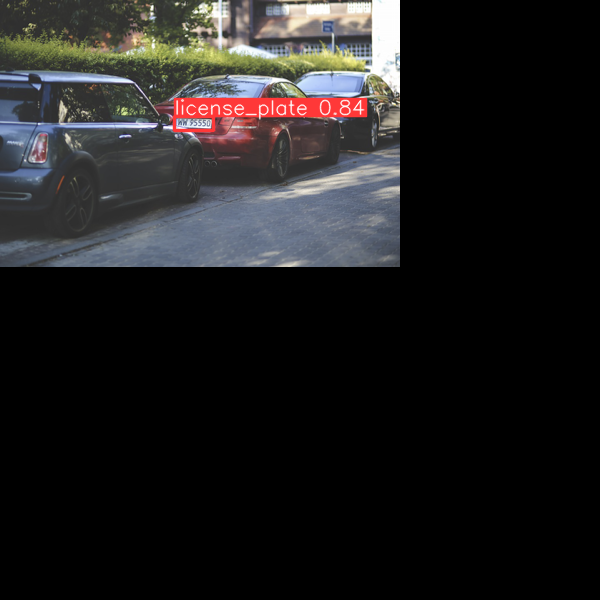

Saved 1 image to results39


In [ ]:
# set image
img = "/content/drive/MyDrive/01-License Plates/paddedimages/Cars100.png"

# perform inference
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

# save results into "results/" folder
results.save(save_dir='results/')

# Obfuscate and Save Image

<Figure size 640x480 with 0 Axes>

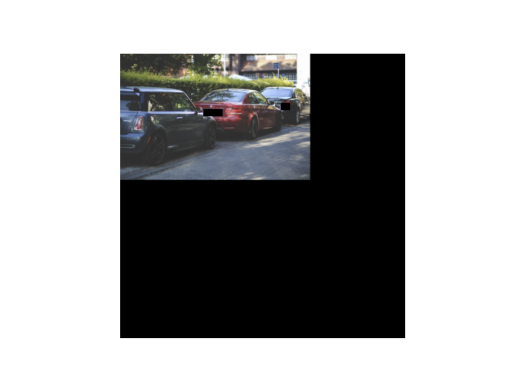

In [ ]:
%matplotlib inline

# we draw stuff
plt.figure()

fig, ax = plt.subplots()
image = mpimg.imread(img)

ax.imshow(image)
for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

plt.axis('off')

plt.savefig("/content/drive/MyDrive/01-License Plates/obfuscatedimages/Cars100.png")
plt.show()

In [ ]:
plt.close()

# Test Obfuscated Image in Pre-Trained Model

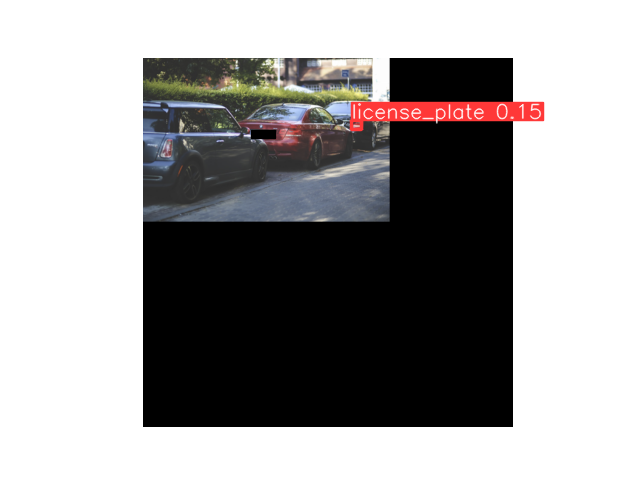

Saved 1 image to results41


In [ ]:
model.conf = 0.1  # NMS confidence threshold

# set image
img = "/content/drive/MyDrive/01-License Plates/obfuscatedimages/Cars100.png"

# perform inference
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

# save results into "results/" folder
results.save(save_dir='results/')

In [ ]:
# we draw stuff
fig, ax = plt.subplots()
image = mpimg.imread(img)

ax.imshow(image)
box = boxes[0]
# x1, y1, x2, y2
# Red box around to see the license plate
#box = box_locations[int(path[4:-4])]
rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

# 4. Testing YOLO5

In [ ]:
loss = 0
images_limits = 100
images_processed = 0

# Loop through all data points
for i, data in enumerate(license_plates_dataset):
  # 10 images limit
  if i > images_limits:
    break

  image, box = data

  # perform inference
  results = model(image, size=640)

  # inference with test time augmentation
  results = model(image, augment=True)

  # parse results
  predictions = results.pred[0]
  boxes = predictions[:, :4] # x1, y1, x2, y2
  processed_box = boxes[0]

  # add loss
  for i in range(len(processed_box)):
    loss += abs(processed_box[i] - box[i])

  images_processed += 1

# Loss
print("Pixel Differences: ", loss/images_processed)

Pixel Differences:  tensor(22.41912)
